In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from saxs_data_processing import io, manipulate, target_comparison, subtract
import pandas as pd

## Load scattering data

## Set parameters for processing

In [11]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1024 # number of grid points to interpolate q on.

## Calculate target scattering

## Run processing for 'best' scattering example

In [7]:
I_scaled = np.load('I_scaled_a6ee3a08-02cd-4703-9d6c-3721dad590c8.npy')
target_I = np.load('I_target.npy')
q_grid = np.load('q_grid_example.npy')

## Plot target and processed measurement

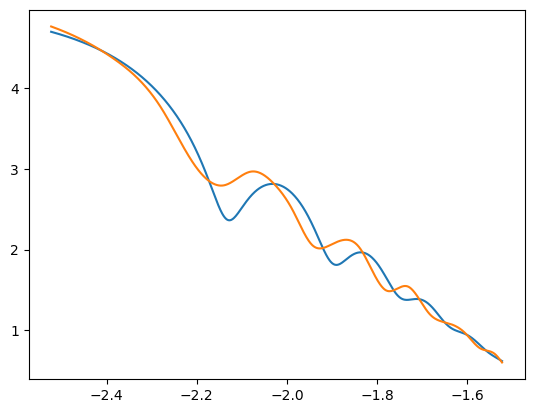

In [8]:
fig, ax = plt.subplots()
ax.plot(q_grid, target_I)
ax.plot(q_grid, I_scaled)
plt.show()

### Using PyTorch version

In [9]:
t = (q_grid - min(q_grid))/(max(q_grid) - min(q_grid))

In [12]:
from apdist.torch import AmplitudePhaseDistance as torch_apdist 
import torch 
optim_kwargs = {"n_iters":50, 
                "n_basis":15, 
                "n_layers":15,
                "domain_type":"linear",
                "basis_type":"palais",
                "n_restarts":50,
                "lr":1e-1,
                "n_domain":n_interpolate_gridpts
                }
amplitude, phase, output = torch_apdist(torch.from_numpy(t), # all the inputs should be torch.Tensor
                                        torch.from_numpy(target_I), 
                                        torch.from_numpy(I_scaled), 
                                        **optim_kwargs
                                        )
print("Amplitude : %2.4f, Phase : %2.4f"%(amplitude, phase))

tensor(0.9475)
tensor(1.4097, dtype=torch.float64)
Amplitude : 1.1873, Phase : 0.3255


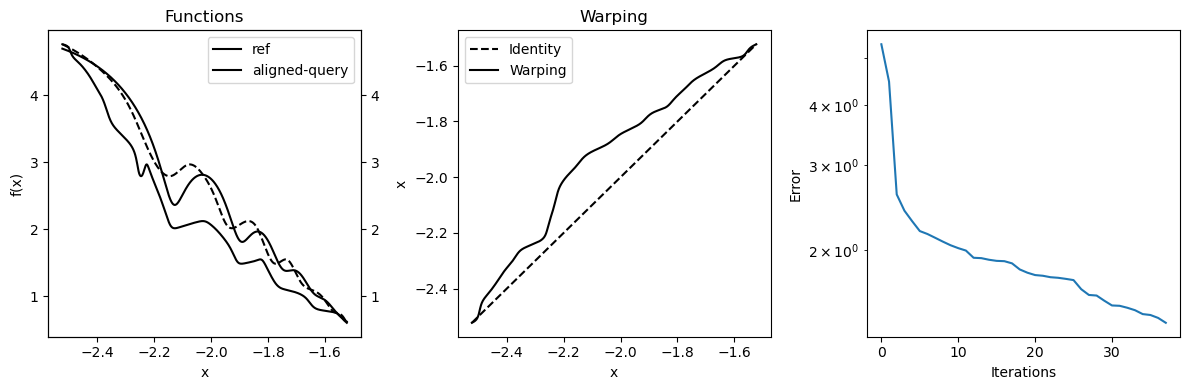

In [14]:
from apdist.torch import plot_warping as plot_warping_torch

plot_warping_torch(q_grid, target_I, I_scaled, output)

### Using Numpy version

In [15]:
from apdist.distances import AmplitudePhaseDistance as dist

optim_kwargs = {"optim":"DP", "grid_dim":10}
dist(t, target_I, I_scaled, **optim_kwargs)

(0.34283261234188767, 0.16181550480781765)

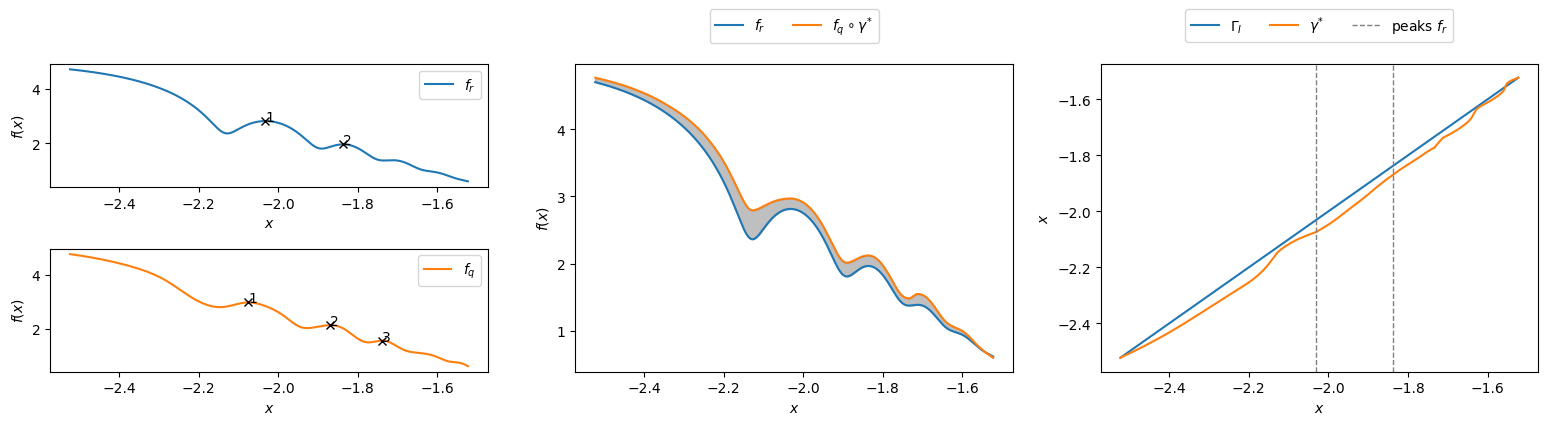

In [16]:
# Plot warped functions and gamma 
from apdist.utils import plot_warping 
from apdist.geometry import SquareRootSlopeFramework as SRSF

# for SRSF representation, we map the domain into [0,1]
srsf = SRSF(t)
q_ref = srsf.to_srsf(target_I)
q_query = srsf.to_srsf(I_scaled)
gamma = srsf.get_gamma(q_ref, q_query, **optim_kwargs)
f_query_gamma = srsf.warp_f_gamma(I_scaled, gamma)
plot_warping(q_grid, target_I, I_scaled, f_query_gamma, gamma)
plt.show()